In [1]:
from tensorflow import keras
import numpy as np
import random
from tensorflow.image import resize
import cv2
from itertools import islice
#from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import copy
import tensorflow as tf
from tensorflow.keras import backend as K
import json, torch
from sklearn.metrics import confusion_matrix, classification_report

### Misc Functions

In [7]:
def resize_and_process_images_for_model(image_set, model):
    '''Function to resize image sets based on give model'''
    if model == 'lenet5':
        images_resized = np.expand_dims(image_set, axis=-1) # Add channel
        # convert image values from integers to floats
        images_resized = images_resized.astype('float32')
        # normalization
        images_resized = images_resized/255.0
        # resize
        images_resized = resize(images_resized, [32,32], antialias=True, method='bilinear') # if we want to resize
        images_resized = images_resized.numpy() # Need to convert to numpy to prevent error when using train_test_split()

    if model == 'vgg16':
        images_resized = np.expand_dims(image_set, axis=-1) #add new dimension at the end of the array shape.
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Repeat the channel dimension three times
        # convert image values from integers to floats
        images_resized = images_resized.astype('float32')
        # normalization
        images_resized = images_resized/255.0
        images_resized = resize(images_resized, [48,48], antialias=True, method='bilinear') # if we want to resize
        images_resized = images_resized.numpy() # Need to convert to numpy to prevent error when using train_test_split()
        #images_resized = np.dstack([images_resized] * 3) # Alternate method to add channels
    
    if model == 'inceptionv1':
        images_resized = np.expand_dims(image_set, axis=-1) #add new dimension at the end of the array shape.
        images_resized = np.repeat(images_resized, 3, axis=-1)  # Repeat the channel dimension three times
        # convert image values from integers to floats
        images_resized = images_resized.astype('float32')
        # normalization
        images_resized = images_resized/255.0
        images_resized = resize(images_resized, [224,224], antialias=True, method='bilinear') # if we want to resize 
        images_resized = images_resized.numpy()  # Need to convert to numpy to prevent error when using train_test_split()
        #images_resized = np.dstack([images_resized] * 3) # Alternate method to add channels
        
    print(f'Image set resized for {model}. New shape is:', images_resized.shape)
    
    return images_resized

def show_images(images, title_texts):
    '''Function to show set of grayscale images with titles'''
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
        
def show_history_loss(history):
    '''Function to show history loss after model training'''
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'test_loss'], loc='best')
    plt.show()

def show_history_accuracy(history):
    '''Function to show history accuracy after model training'''
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

### Load in Model

In [75]:
from LeNet5_no_softmax import *
LeNet_model = LeNet()

### Load Mnist Dataset

In [9]:
# Loading dataset from keras (ref: https://keras.io/api/datasets/mnist/)
(x_train,y_train),(x_test,y_test)= keras.datasets.mnist.load_data()

# Print shapes
print('x_train shape: ', x_train.shape) # Train images
print('y_train shape: ', y_train.shape) # Train Labels
print('x_test shape: ', x_test.shape) # Test images
print('y_test shape: ', y_test.shape) # Test labels

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


### Show Mnist Images

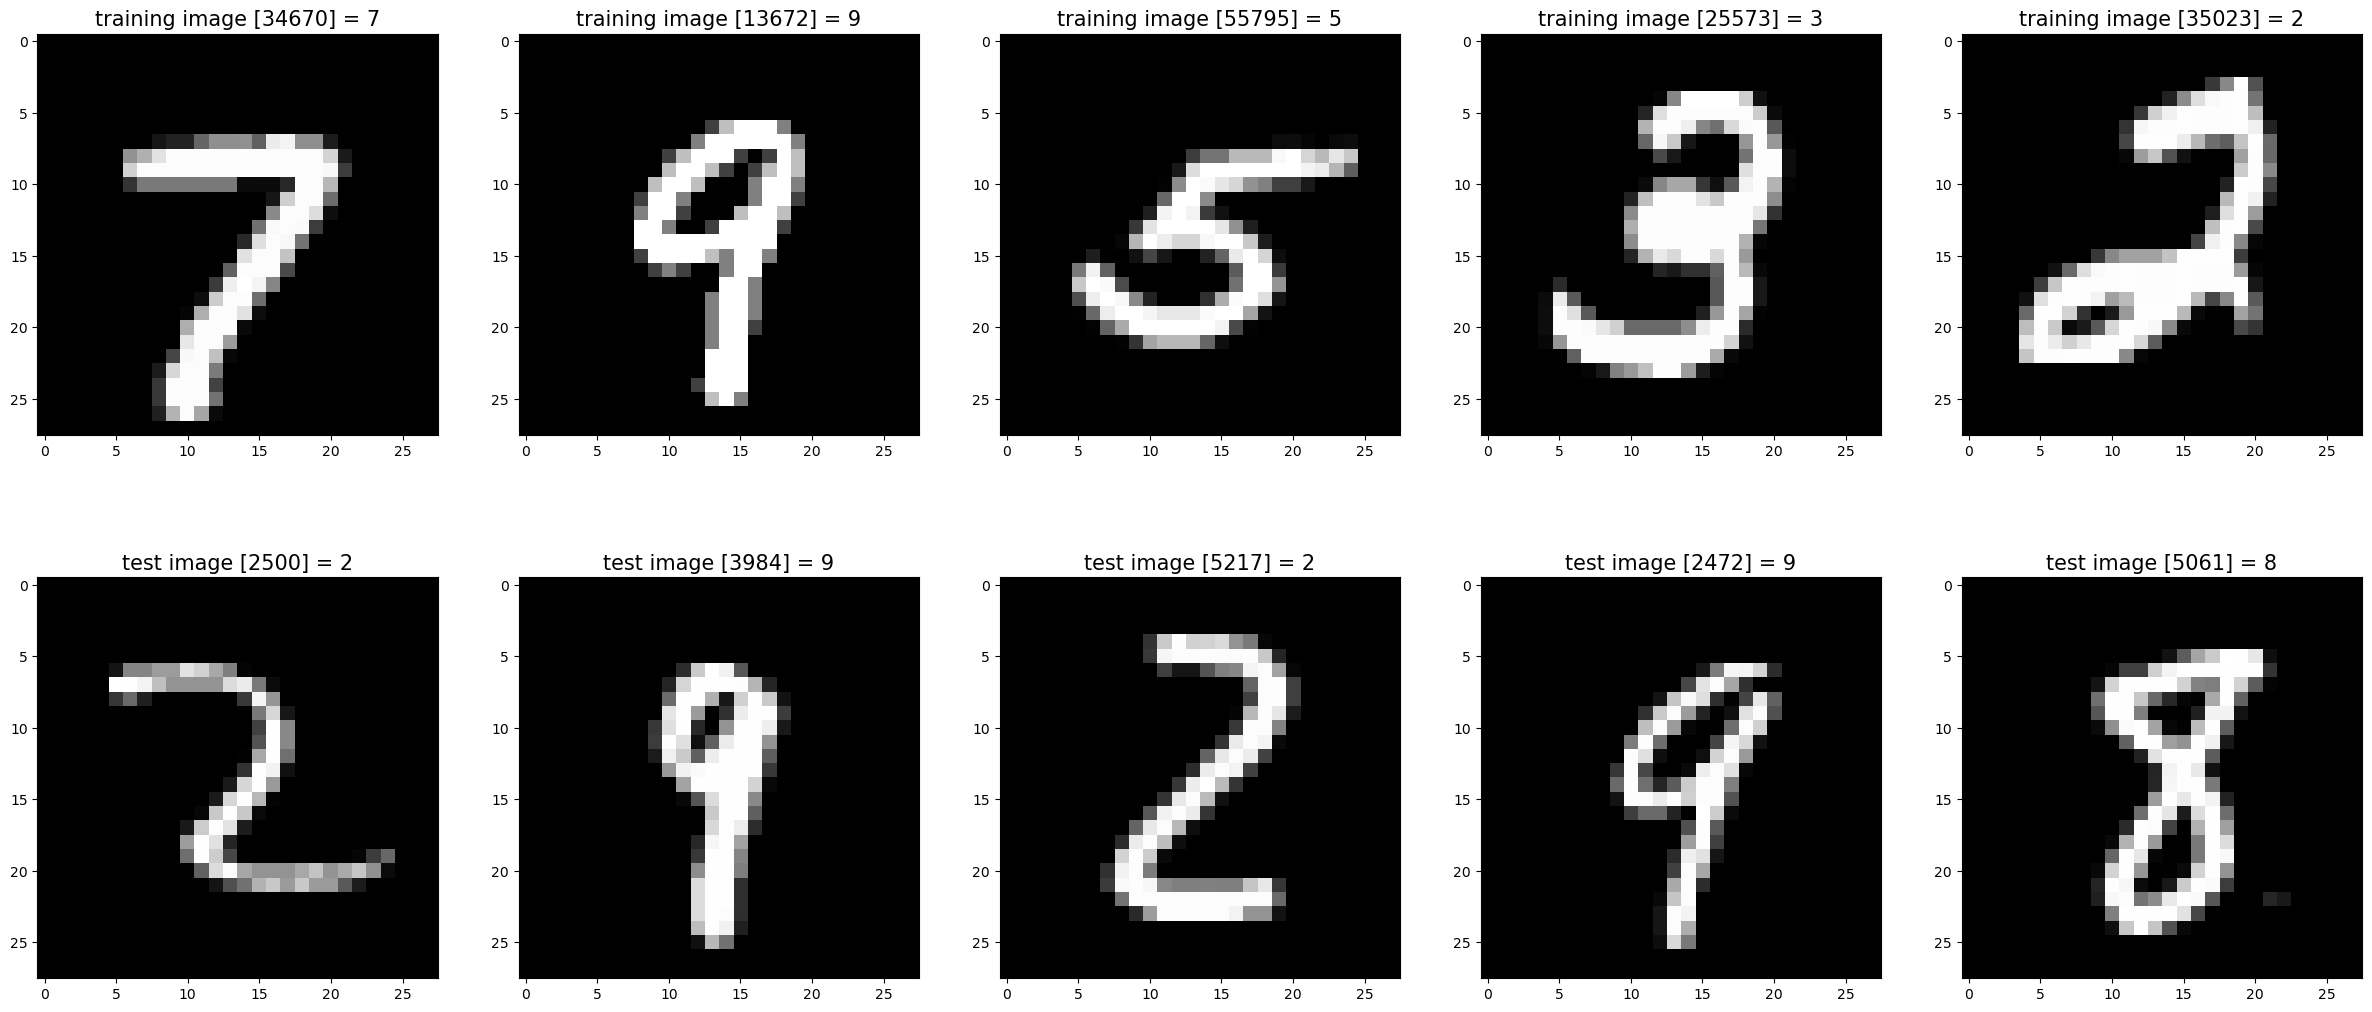

In [114]:
# Show some random training and test images 
images_show = [] # random images placeholder
titles_show = [] # random images title placeholder
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_show.append(x_train[r])
    titles_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_show.append(x_test[r])        
    titles_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_show, titles_show)

### Resize images

In [10]:
# Resize training images for LeNet5
lenet_xtest = resize_and_process_images_for_model(x_test, 'lenet5')

# Resize training images for LeNet5
lenet_xtrain = resize_and_process_images_for_model(x_train, 'lenet5')

Image set resized for lenet5. New shape is: (10000, 32, 32, 1)
Image set resized for lenet5. New shape is: (60000, 32, 32, 1)


In [116]:
# Show model summary
print(LeNet_model.summary(), '\n')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

## Model Training

In [76]:
from sklearn.model_selection import train_test_split

# Initialize parameters
rand_seed = 12345
val_size = 0.2
noise_std = 1

# Create LeNet5 Training and Validation data set
lenet_train_imgs, lenet_val_imgs, lenet_train_enc_label, lenet_val_enc_label = train_test_split(lenet_xtrain, y_train, test_size=val_size, random_state=rand_seed)
print('lenet_train_imgs shape: ', lenet_train_imgs.shape)
print('lenet_val_imgs shape: ', lenet_val_imgs.shape)
print('lenet_train_labels shape: ', lenet_train_enc_label.shape)
print('lenet_val_labels shape: ', lenet_val_enc_label.shape)

lenet_train_imgs shape:  (48000, 32, 32, 1)
lenet_val_imgs shape:  (12000, 32, 32, 1)
lenet_train_labels shape:  (48000,)
lenet_val_labels shape:  (12000,)


In [77]:
# TRAIN FUNCTION FOR LENET
def train_lenet_model(model, batch_size=64, n_epochs=20, seed=42):
    # Determine number of samples in training and validation set
    num_train_samples = len(lenet_train_imgs)
    num_vali_samples = len(lenet_val_imgs)
    
    # Compute number of training and validation steps for each epoch
    steps_train = num_train_samples // batch_size
    steps_vali = num_vali_samples // batch_size
    
    # Add 1 more step if there are remaining samples after integer division
    if num_train_samples % batch_size != 0:
        steps_train += 1

    if num_vali_samples % batch_size != 0:
        steps_vali += 1
        

    for i in range(n_epochs):
        # Smooth input images
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=noise_std)
        values = initializer(shape=lenet_train_imgs.shape)
        lenet_train_imgs_smooth = lenet_train_imgs + values
        # Start training
        model.fit(
            lenet_train_imgs_smooth, 
            lenet_train_enc_label,
            steps_per_epoch=steps_train,
            epochs=1,
            validation_data=(lenet_val_imgs,lenet_val_enc_label),
            validation_steps=steps_vali,
            verbose=1
        )
    return model

In [78]:
import json

lenet_history = train_lenet_model(LeNet_model)
# Store the trained model in file
LeNet_model.save("./model_LeNet_no_softmax_smoothed_1.h5")

# Save history to a json file
#json.dump(lenet_history.history, open('lenet_history_no_softmax_smoothed_1.json', 'w'))


750/750 [==============================] - 3s 4ms/step - loss: 0.3560 - accuracy: 0.8804 - val_loss: 0.0875 - val_accuracy: 0.9762


C:\Users\Ty\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Eval

In [79]:
from keras.models import load_model
LeNet_model = load_model('model_LeNet_no_softmax_smoothed_1.h5')

# Alternate way to test
LeNet_loss, LeNet_accuracy = LeNet_model.evaluate(lenet_xtest, y_test, verbose=1)
print("LeNet Test Accuracy:", LeNet_accuracy)

lenet_xtest_output = LeNet_model.predict(lenet_xtest)
lenet_xtest_preds = np.argmax(lenet_xtest_output, axis=1)
print('lenet_xtest_preds: ', lenet_xtest_preds)
print('y_test:', y_test)
# Print confusion matrix
print("LeNet Confusion Matrix:")
print(confusion_matrix(y_test,lenet_xtest_preds))

# Print classification report
print("\nLeNet Classification Report:")
print(classification_report(y_test,lenet_xtest_preds))

#lenet_history_dict = json.load(open('lenet_history_no_softmax_smoothed_1.json', 'r'))
#show_history_loss(lenet_history_dict)
#show_history_accuracy(lenet_history_dict)

313/313 [==============================] - 1s 1ms/step - loss: 0.0768 - accuracy: 0.9767
LeNet Test Accuracy: 0.9767000079154968
313/313 [==============================] - 0s 1ms/step
lenet_xtest_preds:  [7 2 1 ... 4 5 6]
y_test: [7 2 1 ... 4 5 6]
LeNet Confusion Matrix:
[[ 975    0    0    0    0    1    2    1    1    0]
 [   0 1126    4    1    0    0    2    0    2    0]
 [   7    1 1005    3    1    0    1   10    4    0]
 [   0    0    2  990    0    4    0    9    5    0]
 [   0    2    3    0  958    0    4    1    1   13]
 [   4    0    0   12    2  861    8    1    2    2]
 [   8    3    0    0    1    2  942    0    2    0]
 [   1    9    9    1    0    0    0  996    2   10]
 [   4    2    1    4    2    2    2    6  946    5]
 [   5    6    1    8    8    2    0    8    3  968]]

LeNet Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
    

## Model Eval on Deepfool

In [80]:
import pickle

# Load in Deepfool Data
adv_data = []
with (open("../LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_images/lenet_test_adv_images.pickle", "rb")) as openfile:
    while True:
        try:
            adv_data.append(pickle.load(openfile))
        except EOFError:
            break
            
orig_labels = []
with (open("../LeNet_Adversarial_Data/adv_mnist_xtest/Original_test_pred_labels/lenet_test_orig_labels.pickle", "rb")) as openfile:
    while True:
        try:
            orig_labels.append(pickle.load(openfile))
        except EOFError:
            break
adv_data = np.array(adv_data[0])
orig_labels = np.array(orig_labels[0])

In [81]:
from keras.models import load_model
LeNet_model = load_model('model_LeNet_no_softmax_smoothed_1.h5')

# Alternate way to test
LeNet_loss, LeNet_accuracy = LeNet_model.evaluate(adv_data, orig_labels, verbose=1)
print("LeNet Test Accuracy:", LeNet_accuracy)

lenet_xtest_output = LeNet_model.predict(adv_data)
lenet_xtest_preds = np.argmax(lenet_xtest_output, axis=1)
print('lenet_xtest_preds: ', lenet_xtest_preds)
print('y_test:', orig_labels)
# Print confusion matrix
print("LeNet Confusion Matrix:")
print(confusion_matrix(orig_labels,lenet_xtest_preds))

# Print classification report
print("\nLeNet Classification Report:")
print(classification_report(orig_labels,lenet_xtest_preds))


313/313 [==============================] - 1s 1ms/step - loss: 0.1512 - accuracy: 0.9566
LeNet Test Accuracy: 0.95660001039505
313/313 [==============================] - 0s 1ms/step
lenet_xtest_preds:  [7 2 1 ... 4 5 6]
y_test: [7 2 1 ... 4 5 6]
LeNet Confusion Matrix:
[[ 970    0    0    0    0    0    3    0    1    0]
 [   1 1131    3    2    0    1    0    3    3    0]
 [  11    2 1007    8    1    1    3    8    4    3]
 [   1    2    8  974    0   18    2   10    4    8]
 [   1    1    4    0  910    0    3    1    1   66]
 [   8    0    0   19    2  826   14    1    7    5]
 [  16    1    0    0    3    2  933    0    0    0]
 [   3    7    2    0    6    1    0  980    2   36]
 [  11    3    5   14   11    9   12    3  903   20]
 [   7    1    0    3    4    1    0    6    1  932]]

LeNet Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       974
           1       0.99      0.99      0.99      1144
      

In [131]:
from keras.models import load_model
LeNet_model = load_model('model_LeNet_no_softmax.h5')

# Alternate way to test
LeNet_loss, LeNet_accuracy = LeNet_model.evaluate(adv_data, orig_labels, verbose=1)
print("LeNet Test Accuracy:", LeNet_accuracy)

lenet_xtest_output = LeNet_model.predict(adv_data)
lenet_xtest_preds = np.argmax(lenet_xtest_output, axis=1)
print('lenet_xtest_preds: ', lenet_xtest_preds)
print('y_test:', orig_labels)
# Print confusion matrix
print("LeNet Confusion Matrix:")
print(confusion_matrix(orig_labels,lenet_xtest_preds))

# Print classification report
print("\nLeNet Classification Report:")
print(classification_report(orig_labels,lenet_xtest_preds))

#lenet_history_dict = json.load(open('lenet_history_no_softmax_smoothed.json', 'r'))
#show_history_loss(lenet_history_dict)
#show_history_accuracy(lenet_history_dict)

313/313 [==============================] - 1s 2ms/step - loss: 0.7284 - accuracy: 0.0010
LeNet Test Accuracy: 0.0010000000474974513
313/313 [==============================] - 0s 1ms/step
lenet_xtest_preds:  [3 3 2 ... 8 8 4]
y_test: [7 2 1 ... 4 5 6]
LeNet Confusion Matrix:
[[  0  10 174  17  42  90 366 108  52 115]
 [  0   1 103  14   3   0  88 632 280  23]
 [ 42 227   0 304  55   9 109 157 126  19]
 [  9  24 190   3   3 327   3  30 339  99]
 [  1   8  58   6   0  29  95 161 182 447]
 [ 30   5   7 323   5   0 123  30 314  45]
 [103  19 103  18 377  96   1   0 234   4]
 [  4  25 381 229  42  61   0   1  78 216]
 [ 30  26 270 324  38 140  67  45   3  48]
 [  6   9   5  73 473  35   1 207 145   1]]

LeNet Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       974
           1       0.00      0.00      0.00      1144
           2       0.00      0.00      0.00      1048
           3       0.00      0.00      0.00    

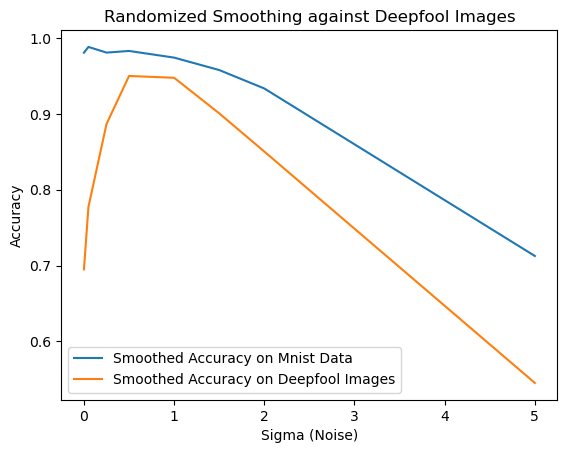

In [69]:
smoothed_mnist_acc = [(0, .9807), (0.05, 0.9883), (0.25, 0.9808), (0.5, .9830), (1, .9742), (1.5, 0.9578), (2, 0.9335), (5, .7126)]
smoothed_mnist_acc_deepfool = [(0, .695), (0.05, 0.7774), (0.25, 0.8866), (0.5, .95), (1, .9476), (1.5, 0.9007), (2, 0.8503), (5, .5452)]

x1, y1 = zip(*smoothed_mnist_acc)
x2, y2 = zip(*smoothed_mnist_acc_deepfool)
# Plot both arrays on the same plot
plt.plot(x1, y1, label='Smoothed Accuracy on Mnist Data')
plt.plot(x2, y2, label='Smoothed Accuracy on Deepfool Images')

# Add labels and a legend
plt.title("Randomized Smoothing against Deepfool Images")
plt.xlabel('Sigma (Noise)')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

### Show Random Smoothed Images

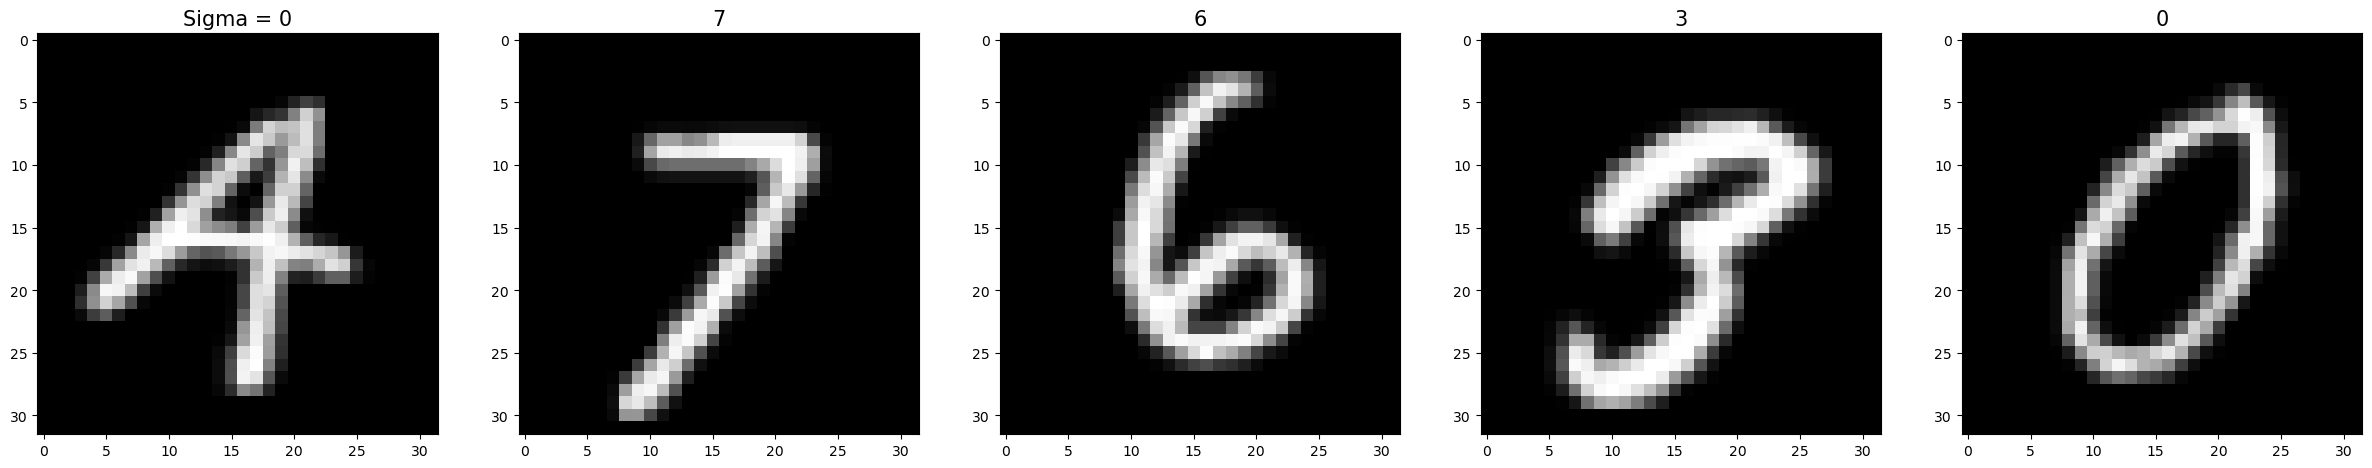

In [70]:
stddev = 0
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=noise_std)
values = initializer(shape=lenet_train_imgs.shape)
lenet_train_imgs_smooth = lenet_train_imgs
show_images(lenet_train_imgs_smooth[0:5], ["Sigma = 0", "7", "6", "3", "0"])

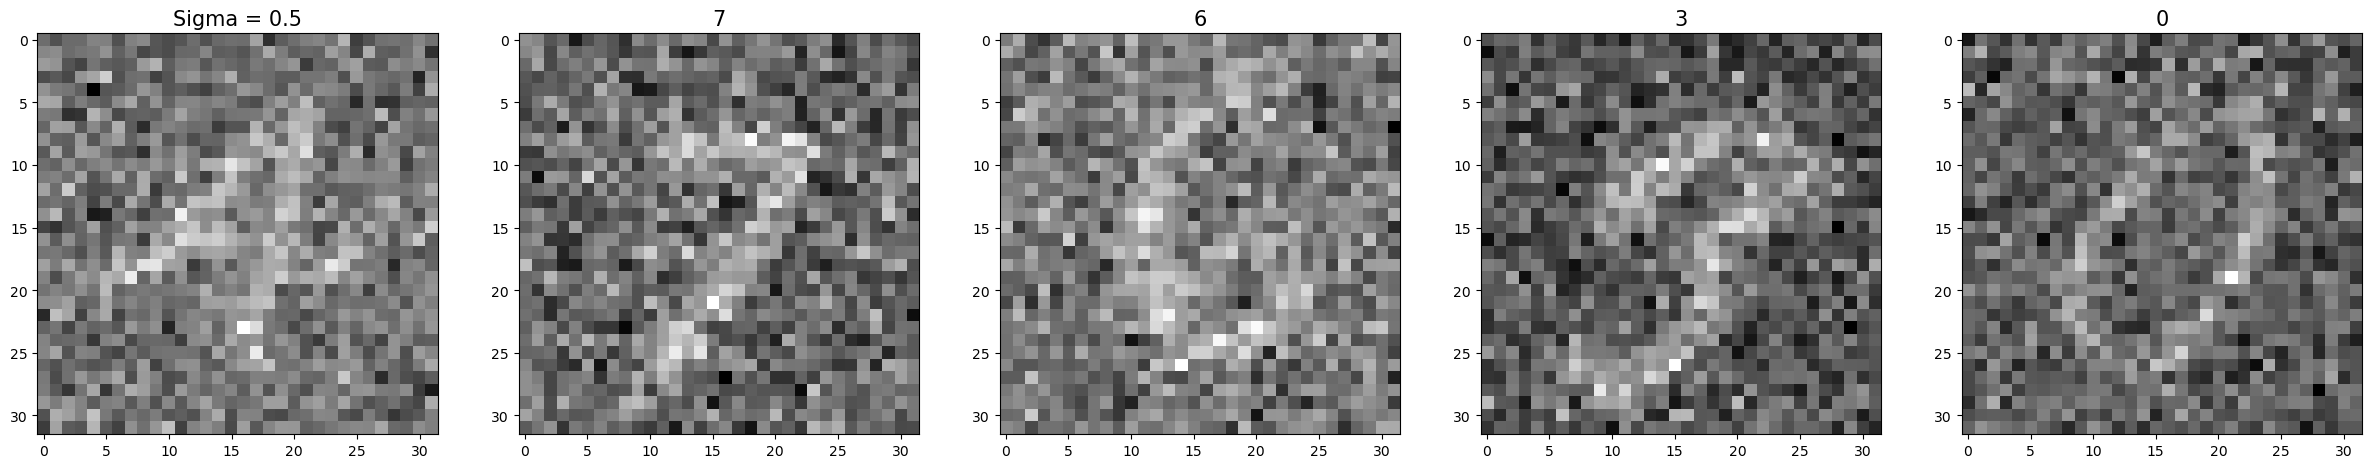

In [71]:
noise_std = 0.5
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=noise_std)
values = initializer(shape=lenet_train_imgs.shape)
lenet_train_imgs_smooth = lenet_train_imgs + values
show_images(lenet_train_imgs_smooth[0:5],["Sigma = 0.5", "7", "6", "3", "0"])

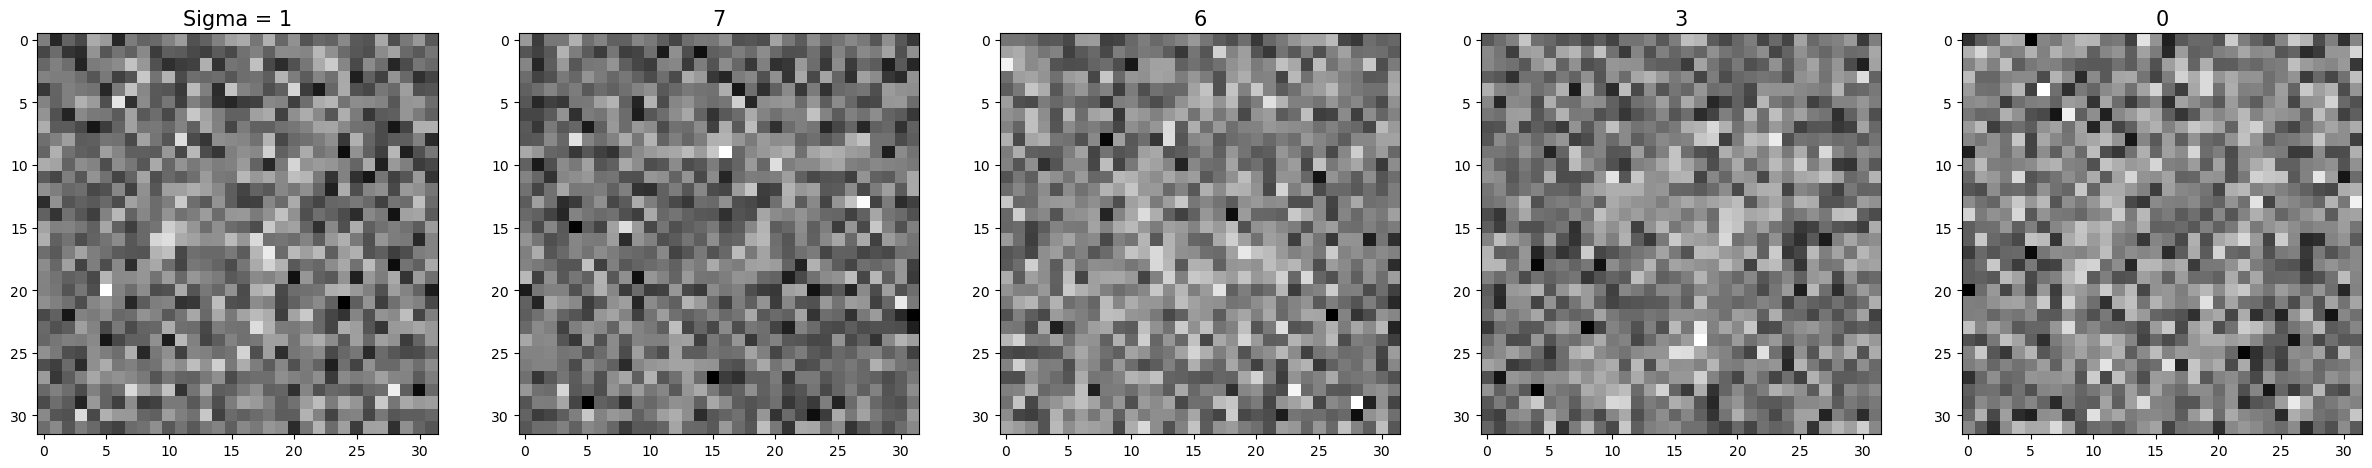

In [72]:
noise_std = 1
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=noise_std)
values = initializer(shape=lenet_train_imgs.shape)
lenet_train_imgs_smooth = lenet_train_imgs + values
show_images(lenet_train_imgs_smooth[0:5], ["Sigma = 1", "7", "6", "3", "0"])

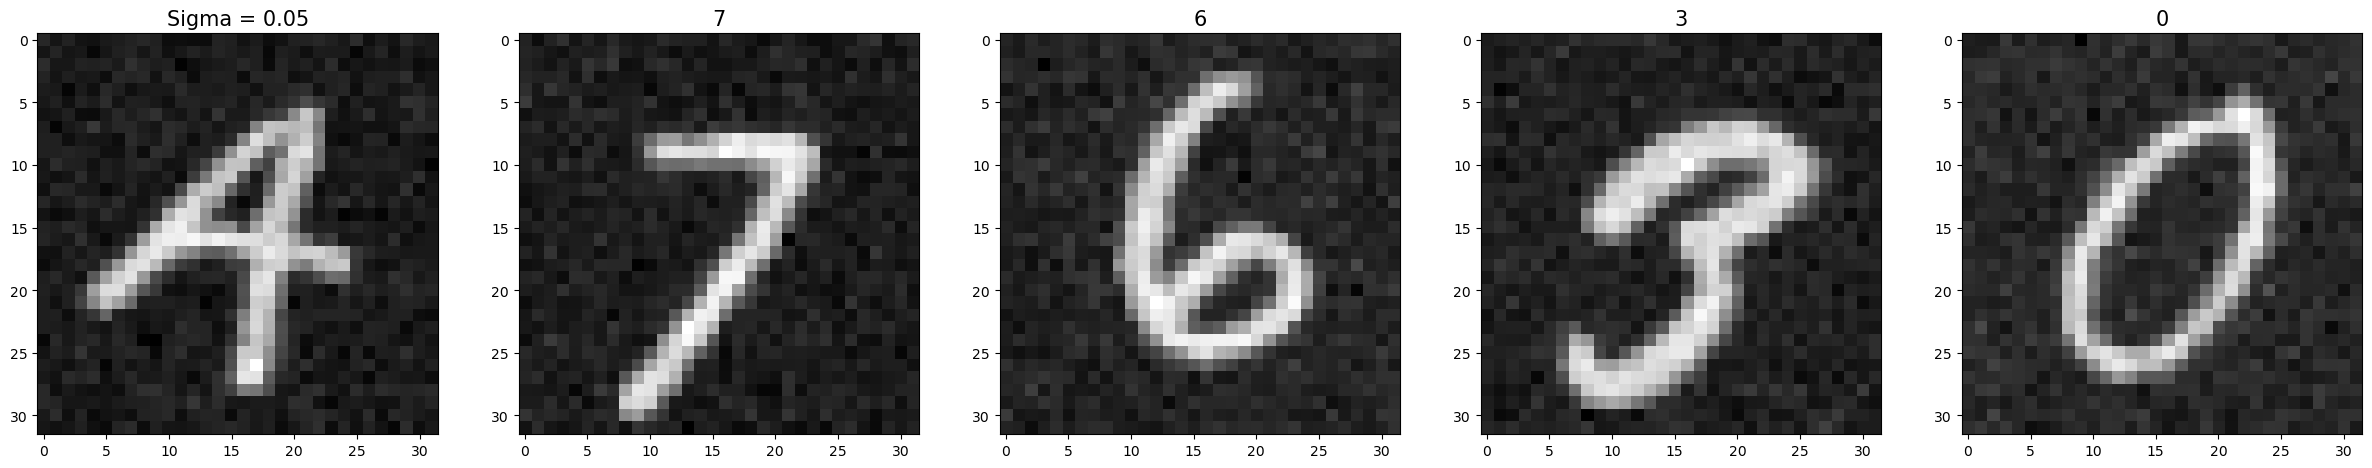

In [73]:
noise_std = 0.05
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=noise_std)
values = initializer(shape=lenet_train_imgs.shape)
lenet_train_imgs_smooth = lenet_train_imgs + values
show_images(lenet_train_imgs_smooth[0:5], ["Sigma = 0.05", "7", "6", "3", "0"])

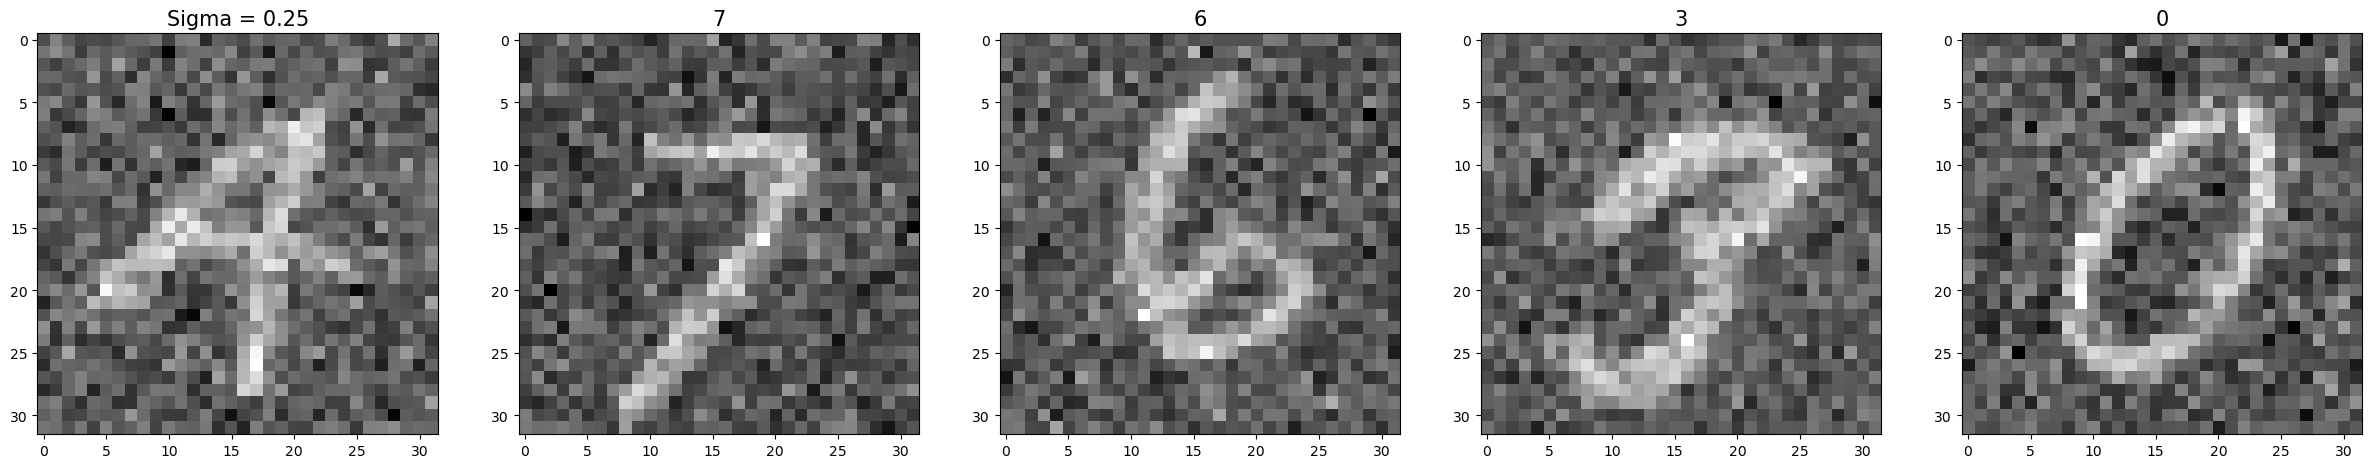

In [74]:
noise_std = 0.25
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=noise_std)
values = initializer(shape=lenet_train_imgs.shape)
lenet_train_imgs_smooth = lenet_train_imgs + values
show_images(lenet_train_imgs_smooth[0:5], ["Sigma = 0.25", "7", "6", "3", "0"])